In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


# Import des librairies et du dataset d'entrainement

In [3]:
####
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
import pickle
import gc
import lightgbm as lgb
warnings.filterwarnings('ignore')
%matplotlib inline
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from imblearn.pipeline import make_pipeline, Pipeline

In [4]:
####
app_train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')

print('The shape of data:',app_train.shape)
app_train.head()

The shape of data: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0



* le dataset d'entrainement contient 307511 lignes et 122 colonnes
* Chaque ligne possède un identifiant (client ou crédit?)
* La colonne target indique si le prêt a été remboursé ou non: '0' prêt remboursé, '1' le prêt n'a pas été remboursé


In [5]:
####
# Testing data features
app_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### traitement des données manquantes (à compléter)


## Encodage des variables
On utilise labe econding pour les variables binaires, pour les autres on encode avec one-hot encoding

In [6]:
####
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [7]:
####
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


## Alignement des données d'entrainement et de test
On aligne les colonnes. On exclue temporairement la cible qui n'est pas présente dans le dataset de test

In [8]:
####
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


Les deux datasets ont maintenant les mêmes features

In [9]:
####
app_train['Age']=round(app_train['DAYS_BIRTH']/(-365))


Impact de l'experience professionelle 

In [10]:
####
app_train['Experience']=round(app_train['DAYS_EMPLOYED']/(365))

On flag les lignes dont l'expérience est en anomalie

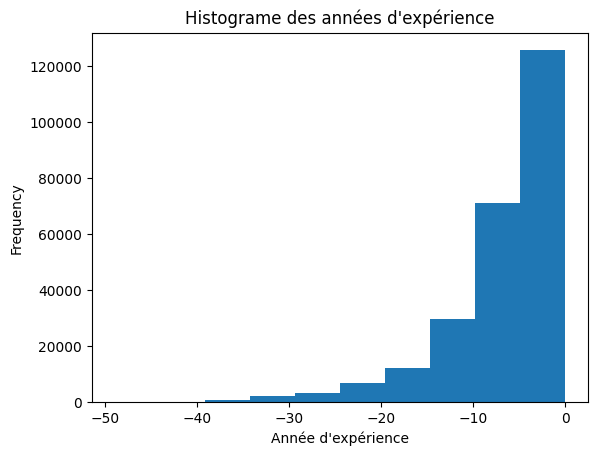

In [11]:
####
# On crée une colonne qui flague les anomalies
app_train['Experience_ano'] = app_train["Experience"] == 1001

# On remplace les données en anomalie par nan
app_train['Experience'].replace({1001: np.nan}, inplace = True)

app_train['Experience'].plot.hist(title = "Histograme des années d'expérience");
plt.xlabel("Année d'expérience");

On aligne le dataset de test

In [12]:
####
app_test['Experience']=round(app_test['DAYS_EMPLOYED']/(365))

In [13]:
####
app_test['Experience_ano'] = app_test['Experience'] == 1001
app_test["Experience"].replace({1001: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test['Experience_ano'].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


Les corrélations les plus importantes sont les jours depuis la  naissance, l'expérience le niveau d'éducation

Impact de l'age sur le remboursement

In [14]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
                              


## Feature Engineering

In [15]:
####
# Flag to represent when Total income is greater than Credit
app_train['INCOME_GT_CREDIT_FLAG'] = app_train['AMT_INCOME_TOTAL'] > app_train['AMT_CREDIT']
# Column to represent Credit Income Percent
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
# Column to represent Annuity Income percent
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
# Column to represent Credit Term
app_train['CREDIT_TERM'] = app_train['AMT_CREDIT'] / app_train['AMT_ANNUITY'] 
# Column to represent Days Employed percent in his life
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']
# Shape of Application data
print('The shape of application data:',app_train.shape)

The shape of application data: (307511, 248)


## Feature engineering des données du fichier Bureau¶

Import des données de Bureau Data

In [16]:
####
bureau = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')

On fusonne les données de bureaux avec les données d'entrainement

In [17]:
####
# on ajoute les données non numériques par SK_ID_CURR
bureau_categorical = pd.get_dummies(bureau.select_dtypes('object'))
bureau_categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']

In [18]:
####
grp = bureau_categorical.groupby(by = ['SK_ID_CURR']).mean().reset_index()
grp.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in grp.columns]
application_bureau = app_train.merge(grp, on='SK_ID_CURR', how='left')
application_bureau.update(application_bureau[grp.columns].fillna(0))

In [19]:
####
#On ajoute les données numériques
grp_num = bureau.drop(['SK_ID_BUREAU','CREDIT_ACTIVE','CREDIT_CURRENCY','CREDIT_TYPE'], axis = 1).groupby(by=['SK_ID_CURR']).mean().reset_index()
grp_num.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in grp_num.columns]
application_bureau = application_bureau.merge(grp_num, on='SK_ID_CURR', how='left')
application_bureau.update(application_bureau[grp_num.columns].fillna(0))

In [20]:
####
# Number of past loans per customer
grp = bureau.groupby(by = ['SK_ID_CURR'])['SK_ID_BUREAU'].count().reset_index().rename(columns = {'SK_ID_BUREAU': 'BUREAU_COUNT'})
application_bureau = application_bureau.merge(grp, on='SK_ID_CURR', how='left')
application_bureau['BUREAU_COUNT'] = application_bureau['BUREAU_COUNT'].fillna(0)

In [21]:
####
# Number of types of past loans per customer 
grp = bureau[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})

In [22]:
####
application_bureau = application_bureau.merge(grp, on='SK_ID_CURR', how='left')
application_bureau['BUREAU_LOAN_TYPES'] = application_bureau['BUREAU_LOAN_TYPES'].fillna(0)

In [23]:
####
# Debt over credit ratio 
bureau['AMT_CREDIT_SUM'] = bureau['AMT_CREDIT_SUM'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
grp1 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM': 'TOTAL_CREDIT_SUM'})
grp2 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CREDIT_SUM_DEBT'})
grp1['DEBT_CREDIT_RATIO'] = grp2['TOTAL_CREDIT_SUM_DEBT']/grp1['TOTAL_CREDIT_SUM']
del grp1['TOTAL_CREDIT_SUM']
application_bureau = application_bureau.merge(grp1, on='SK_ID_CURR', how='left')


In [24]:
####
application_bureau['DEBT_CREDIT_RATIO'] = application_bureau['DEBT_CREDIT_RATIO'].fillna(0)


In [25]:
####
application_bureau['DEBT_CREDIT_RATIO'][application_bureau['DEBT_CREDIT_RATIO']==np.inf]= 0

In [26]:
####
application_bureau['DEBT_CREDIT_RATIO'][application_bureau['DEBT_CREDIT_RATIO']== -np.inf]= 0

In [27]:
####
application_bureau['DEBT_CREDIT_RATIO'] = pd.to_numeric(application_bureau['DEBT_CREDIT_RATIO'], downcast='float')

In [28]:
####
# Overdue over debt ratio
bureau['AMT_CREDIT_SUM_OVERDUE'] = bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
grp1 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_OVERDUE': 'TOTAL_CUSTOMER_OVERDUE'})
grp2 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CUSTOMER_DEBT'})
grp1['OVERDUE_DEBT_RATIO'] = grp1['TOTAL_CUSTOMER_OVERDUE']/grp2['TOTAL_CUSTOMER_DEBT']
del grp1['TOTAL_CUSTOMER_OVERDUE']
application_bureau = application_bureau.merge(grp1, on='SK_ID_CURR', how='left')


In [29]:
####
application_bureau['OVERDUE_DEBT_RATIO'] = application_bureau['OVERDUE_DEBT_RATIO'].fillna(0)
application_bureau['OVERDUE_DEBT_RATIO'][application_bureau['OVERDUE_DEBT_RATIO']== np.inf]= 0
application_bureau['OVERDUE_DEBT_RATIO'][application_bureau['OVERDUE_DEBT_RATIO']== -np.inf]= 0
#application_bureau['OVERDUE_DEBT_RATIO'] = application_bureau.replace([np.inf, -np.inf], 0)
application_bureau['OVERDUE_DEBT_RATIO'] = pd.to_numeric(application_bureau['OVERDUE_DEBT_RATIO'], downcast='float')

### Utilisation des données Previous Application data

In [30]:
####
previous_applicaton = pd.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv')

Jointure des données de previous_applicaton avec la base consolidée

In [120]:
####
# Number of previous applications per customer
grp = previous_applicaton[['SK_ID_CURR','SK_ID_PREV']].groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'PREV_APP_COUNT'})
application_bureau_prev = application_bureau.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev['PREV_APP_COUNT'] = application_bureau_prev['PREV_APP_COUNT'].fillna(0)

In [32]:
previous_applicaton.describe(exclude=np.number)

,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1670214,1670214,1670214,1670214,1670214,1670214,1670214,849809,1670214,1670214,1670214,1670214,1670214,1670214,1670214,1669868
unique,4,7,2,25,4,4,9,7,4,28,5,3,8,11,5,17
top,Cash loans,TUESDAY,Y,XAP,Approved,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,747553,255118,1661739,922661,1036781,1033552,1353093,508970,1231261,950809,691011,1063666,719968,855720,517215,285990


In [121]:
####
# Combining categorical features
prev_categorical = pd.get_dummies(previous_applicaton.select_dtypes('object'))
prev_categorical['SK_ID_CURR'] = previous_applicaton['SK_ID_CURR']
prev_categorical.head()
grp = prev_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['PREV_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
#application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [34]:
####
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [122]:
####
# Combining numerical features

prev_numeric = pd.get_dummies(previous_applicaton.select_dtypes('float64','int64'))
prev_numeric['SK_ID_CURR'] = previous_applicaton['SK_ID_CURR']
prev_numeric.head()

grp = prev_numeric.groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['PREV_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

Utilisation du dataset POS_CASH_balance

In [36]:
####
pos_cash = pd.read_csv('/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv')

In [37]:
pos_cash.shape

(10001358, 8)

Jointure des données de compte avec la base consolidée

In [38]:
pos_cash.dtypes

SK_ID_PREV                 int64
SK_ID_CURR                 int64
MONTHS_BALANCE             int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS      object
SK_DPD                     int64
SK_DPD_DEF                 int64
dtype: object

In [123]:
####
# Combining numerical features
grp = pos_cash.drop(['SK_ID_PREV','NAME_CONTRACT_STATUS'], axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['POS_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [124]:
####
# Combining categorical features
pos_cash_categorical = pd.get_dummies(pos_cash.select_dtypes('object'))
pos_cash_categorical['SK_ID_CURR'] = pos_cash['SK_ID_CURR']
grp = pos_cash_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['POS_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

Utilisation des données installment_payment

In [41]:
####
insta_payments= pd.read_csv('/kaggle/input/home-credit-default-risk/installments_payments.csv')

Jointure du dataset installments_payments avec la base consolidée

In [125]:
####
# Combining numerical features and there are no categorical features in this dataset
grp = insta_payments.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['INSTA_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

Utilisation des données  du fichier Credit card balance

In [43]:
####
credit_card=pd.read_csv('/kaggle/input/home-credit-default-risk/credit_card_balance.csv')

In [126]:
####
# Combining numerical features
grp = credit_card.drop(['SK_ID_PREV','NAME_CONTRACT_STATUS'], axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['CREDIT_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [127]:
####
# Combining categorical features
credit_categorical = pd.get_dummies(credit_card.select_dtypes('object'))
credit_categorical['SK_ID_CURR'] = credit_card['SK_ID_CURR']
grp = credit_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['CREDIT_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [128]:
####
application_bureau_prev.reset_index()

,index,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CREDIT_CNT_INSTALMENT_MATURE_CUM,CREDIT_SK_DPD,CREDIT_SK_DPD_DEF,CREDIT_NAME_CONTRACT_STATUS_Active,CREDIT_NAME_CONTRACT_STATUS_Approved,CREDIT_NAME_CONTRACT_STATUS_Completed,CREDIT_NAME_CONTRACT_STATUS_Demand,CREDIT_NAME_CONTRACT_STATUS_Refused,CREDIT_NAME_CONTRACT_STATUS_Sent proposal,CREDIT_NAME_CONTRACT_STATUS_Signed
0,0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307508,307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307509,307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
# Suppression des colonnes de score EXT_SOURCE et df_index (data leak)
data_leak = [i for i in application_bureau_prev.columns if i.startswith('EXT_SOURCE')]
application_bureau_prev = application_bureau_prev.drop(columns=data_leak)


In [135]:
application_bureau_prev.shape

(307511, 422)

In [49]:
#df train
application_bureau_prev

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CREDIT_CNT_INSTALMENT_MATURE_CUM,CREDIT_SK_DPD,CREDIT_SK_DPD_DEF,CREDIT_NAME_CONTRACT_STATUS_Active,CREDIT_NAME_CONTRACT_STATUS_Approved,CREDIT_NAME_CONTRACT_STATUS_Completed,CREDIT_NAME_CONTRACT_STATUS_Demand,CREDIT_NAME_CONTRACT_STATUS_Refused,CREDIT_NAME_CONTRACT_STATUS_Sent proposal,CREDIT_NAME_CONTRACT_STATUS_Signed
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
application_bureau_prev_s= application_bureau_prev.sample(frac=0.15)
#dfs=application_bureau_prev_s
#application_bureau_prev_s.shape

In [132]:
df_ = application_bureau_prev.drop(columns=['SK_ID_CURR', 'TARGET'])

# calculate correlation matrix

corr_matrix = df_.corr().abs()

In [52]:
df_

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CREDIT_CNT_INSTALMENT_MATURE_CUM,CREDIT_SK_DPD,CREDIT_SK_DPD_DEF,CREDIT_NAME_CONTRACT_STATUS_Active,CREDIT_NAME_CONTRACT_STATUS_Approved,CREDIT_NAME_CONTRACT_STATUS_Completed,CREDIT_NAME_CONTRACT_STATUS_Demand,CREDIT_NAME_CONTRACT_STATUS_Refused,CREDIT_NAME_CONTRACT_STATUS_Sent proposal,CREDIT_NAME_CONTRACT_STATUS_Signed
0,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,9461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,19046,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,19005,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,19932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,9327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,20775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307508,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,14966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307509,0,0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,11961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
# get upper triangle of correlation matrix

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# find features with correlation greater than 0.90

to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# drop highly correlated features

application_bureau_prev.drop(to_drop, axis=1, inplace=True)

In [54]:
application_bureau_prev['TARGET']

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [137]:
df_ = application_bureau_prev.drop(columns=['SK_ID_CURR', 'TARGET'])
df_.shape

(307511, 420)

In [138]:
application_bureau_prev.shape

(307511, 422)

In [57]:
dfs_ = application_bureau_prev_s.drop(columns=['SK_ID_CURR', 'TARGET'])

# calculate correlation matrix

corr_matrix_s = dfs_.corr().abs()

# get upper triangle of correlation matrix

upper_s = corr_matrix_s.where(np.triu(np.ones(corr_matrix_s.shape), k=1).astype(bool))

# find features with correlation greater than 0.90

to_drop_s = [column for column in upper_s.columns if any(upper_s[column] > 0.90)]

# drop highly correlated features

application_bureau_prev_s.drop(to_drop_s, axis=1, inplace=True)

In [58]:
dfs_.shape

(46127, 488)

In [59]:
application_bureau_prev_s.shape

(46127, 427)

Séparation de la base consolidée en 3 datasets: train, validation et test

In [139]:
####


#X = df_.values
#y = df['TARGET'].values

# Fix for error
from sklearn import preprocessing
from sklearn import utils

y = application_bureau_prev.pop('TARGET').values

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y = lab.fit_transform(y)

#X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify = y, test_size=0.3, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify = y_temp, test_size=0.5, random_state=42)

X_train, X_temp, y_train, y_temp = train_test_split(application_bureau_prev.drop(['SK_ID_CURR'],axis=1), y, stratify = y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify = y_temp, test_size=0.5, random_state=42)
print('Shape of X_train:',X_train.shape)
print('Shape of X_val:',X_val.shape)
print('Shape of X_test:',X_test.shape)

Shape of X_train: (215257, 420)
Shape of X_val: (46127, 420)
Shape of X_test: (46127, 420)


In [61]:
#X_s = dfs_.values
#y_s = dfs['TARGET'].values

# Fix for error
from sklearn import preprocessing
from sklearn import utils

y_s = application_bureau_prev_s.pop('TARGET').values

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_s = lab.fit_transform(y_s)

#X_train_s, X_temp_s, y_train_s, y_temp_s = train_test_split(X_s, y_s, stratify = y_s, test_size=0.3, random_state=42)
#X_val_s, X_test_s, y_val_s, y_test_s = train_test_split(X_temp_s, y_temp_s, stratify = y_temp_s, test_size=0.5, random_state=42)


X_train_s, X_temp_s, y_train_s, y_temp_s = train_test_split(application_bureau_prev_s.drop(['SK_ID_CURR'],axis=1), y_s, stratify = y_s, test_size=0.3, random_state=42)
X_val_s, X_test_s, y_val_s, y_test_s = train_test_split(X_temp_s, y_temp_s, stratify = y_temp_s, test_size=0.5, random_state=42)



In [140]:
####
# Seperation of columns into numeric and categorical columns
types = np.array([dt for dt in X_train.dtypes])
all_columns = X_train.columns.values
is_num = types != 'object'
num_cols = all_columns[is_num]
cat_cols = all_columns[~is_num]
# Featurization of numeric data
imputer_num = SimpleImputer(strategy='median')
X_train_num = imputer_num.fit_transform(X_train[num_cols])
X_val_num = imputer_num.transform(X_val[num_cols])
X_test_num = imputer_num.transform(X_test[num_cols])
scaler_num = StandardScaler()
X_train_num1 = scaler_num.fit_transform(X_train_num)
X_val_num1 = scaler_num.transform(X_val_num)
X_test_num1 = scaler_num.transform(X_test_num)
X_train_num_final = pd.DataFrame(X_train_num1, columns=num_cols)
X_val_num_final = pd.DataFrame(X_val_num1, columns=num_cols)
X_test_num_final = pd.DataFrame(X_test_num1, columns=num_cols)
# Featurization of categorical data
imputer_cat = SimpleImputer(strategy='constant', fill_value='MISSING')
#X_train_cat = imputer_cat.fit_transform(X_train[cat_cols])
#X_val_cat = imputer_cat.transform(X_val[cat_cols])
#X_test_cat = imputer_cat.transform(X_test[cat_cols])
#X_train_cat1= pd.DataFrame(X_train_cat, columns=cat_cols)
#X_val_cat1= pd.DataFrame(X_val_cat, columns=cat_cols)
#X_test_cat1= pd.DataFrame(X_test_cat, columns=cat_cols)
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
#X_train_cat2 = ohe.fit_transform(X_train_cat1)
#X_val_cat2 = ohe.transform(X_val_cat1)
#X_test_cat2 = ohe.transform(X_test_cat1)
#cat_cols_ohe = list(ohe.get_feature_names(input_features=cat_cols))
#X_train_cat_final = pd.DataFrame(X_train_cat2, columns = cat_cols_ohe)
#X_val_cat_final = pd.DataFrame(X_val_cat2, columns = cat_cols_ohe)
#X_test_cat_final = pd.DataFrame(X_test_cat2, columns = cat_cols_ohe)
# Final complete data
X_train_final = pd.concat([X_train_num_final], axis = 1)
X_val_final = pd.concat([X_val_num_final], axis = 1)
X_test_final = pd.concat([X_test_num_final], axis = 1)
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)

(215257, 420)
(46127, 420)
(46127, 420)


Création d'un jeu de données moins volumineux pour raccourcir les temps de calculs

In [63]:
#y_s = application_bureau_prev_s.pop('TARGET').values
#X_train_s, X_temp_s, y_train_s, y_temp_s = train_test_split(application_bureau_prev_s.drop(['SK_ID_CURR'],axis=1), y_s, stratify = y_s, test_size=0.3, random_state=42)
#X_val_s, X_test_s, y_val_s, y_test_s = train_test_split(X_temp_s, y_temp_s, stratify = y_temp_s, test_size=0.5, random_state=42)
#print('Shape of X_train_s:',X_train_s.shape)
#print('Shape of X_val_s:',X_val_s.shape)
#print('Shape of X_test_s:',X_test_s.shape)

In [64]:
# Seperation of columns into numeric and categorical columns
types = np.array([dt for dt in X_train_s.dtypes])
all_columns = X_train_s.columns.values
is_num = types != 'object'
num_cols = all_columns[is_num]
cat_cols = all_columns[~is_num]
# Featurization of numeric data
imputer_num = SimpleImputer(strategy='median')
X_train_s_num = imputer_num.fit_transform(X_train_s[num_cols])
X_val_s_num = imputer_num.transform(X_val_s[num_cols])
X_test_s_num = imputer_num.transform(X_test_s[num_cols])
scaler_num = StandardScaler()
X_train_s_num1 = scaler_num.fit_transform(X_train_s_num)
X_val_s_num1 = scaler_num.transform(X_val_s_num)
X_test_s_num1 = scaler_num.transform(X_test_s_num)
X_train_s_num_final = pd.DataFrame(X_train_s_num1, columns=num_cols)
X_val_s_num_final = pd.DataFrame(X_val_s_num1, columns=num_cols)
X_test_s_num_final = pd.DataFrame(X_test_s_num1, columns=num_cols)
# Featurization of categorical data
imputer_cat = SimpleImputer(strategy='constant', fill_value='MISSING')
#X_train_cat = imputer_cat.fit_transform(X_train[cat_cols])
#X_val_cat = imputer_cat.transform(X_val[cat_cols])
#X_test_cat = imputer_cat.transform(X_test[cat_cols])
#X_train_cat1= pd.DataFrame(X_train_cat, columns=cat_cols)
#X_val_cat1= pd.DataFrame(X_val_cat, columns=cat_cols)
#X_test_cat1= pd.DataFrame(X_test_cat, columns=cat_cols)
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
#X_train_cat2 = ohe.fit_transform(X_train_cat1)
#X_val_cat2 = ohe.transform(X_val_cat1)
#X_test_cat2 = ohe.transform(X_test_cat1)
#cat_cols_ohe = list(ohe.get_feature_names(input_features=cat_cols))
#X_train_cat_final = pd.DataFrame(X_train_cat2, columns = cat_cols_ohe)
#X_val_cat_final = pd.DataFrame(X_val_cat2, columns = cat_cols_ohe)
#X_test_cat_final = pd.DataFrame(X_test_cat2, columns = cat_cols_ohe)
# Final complete data
X_train_s_final = pd.concat([X_train_s_num_final], axis = 1)
X_val_s_final = pd.concat([X_val_s_num_final], axis = 1)
X_test_s_final = pd.concat([X_test_s_num_final], axis = 1)
print(X_train_s_final.shape)
print(X_val_s_final.shape)
print(X_test_s_final.shape)

(32288, 425)
(6919, 425)
(6920, 425)


In [65]:
import re
X_train_s_final=X_train_s_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_val_s_final=X_val_s_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_s_final=X_test_s_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [66]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [67]:
X_train_s_final = reduce_mem_usage(X_train_s_final)
X_test_s_final = reduce_mem_usage(X_test_s_final)



# Modélisation

In [68]:
import time

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [69]:
# Custom score function
from sklearn.metrics import make_scorer, det_curve

def cost_function(y_test, y_pred):
    fpr, fnr, thresholds = det_curve(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='all').ravel()
    return 10*fn + fp

custom_scorer = make_scorer(cost_function, greater_is_better=False)

In [70]:
#New Confusion matrix

# Confusion matrix function
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confmat(y_test, y_pred):

    conf_matrix = confusion_matrix(y_test, y_pred, normalize='all')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='all').ravel()
    print('fp : ',fp,'\ntn : ', fn)

    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(8,6), dpi=100)
    # Scale up the size of all text
    sns.set(font_scale = 1.1)

    # Plot Confusion Matrix using Seaborn heatmap()
    # Parameters:
    # first param - confusion matrix in array format   
    # annot = True: show the numbers in each heatmap cell
    # fmt = 'd': show numbers as integers. 
    ax = sns.heatmap(conf_matrix, annot=True, fmt='.2g')

    # set x-axis label and ticks. 
    ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['0', '1'])

    # set y-axis label and ticks
    ax.set_ylabel("Actual", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['0', '1'])

    # set plot title
    ax.set_title("Confusion Matrix for credit default", fontsize=14, pad=20)

    plt.show()

def plot_confusion_matrix(test_y, predicted_y):
    # Confusion matrix
    C = confusion_matrix(test_y, predicted_y)
    
    # Recall matrix
    A = (((C.T)/(C.sum(axis=1))).T)
    
    # Precision matrix
    B = (C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = ['Re-paid(0)','Not Re-paid(1)']
    cmap=sns.light_palette("purple")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap,fmt="d", xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Confusion matrix')
    
    plt.subplot(1,3,2)
    sns.heatmap(A, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Recall matrix')
    
    plt.subplot(1,3,3)
    sns.heatmap(B, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Precision matrix')
    
    plt.show()
def cv_plot(alpha, cv_auc):
    
    fig, ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_auc,c='g')
    for i, txt in enumerate(np.round(cv_auc,3)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_auc[i]))
    plt.grid()
    plt.xticks(np.log10(alpha))
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

Dummy Classifier

In [71]:
# Definition of the models to train and test

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randint
from imblearn.over_sampling import BorderlineSMOTE

# transform the dataset


oversample = BorderlineSMOTE()
X_train_s_final, y_train_s = oversample.fit_resample(X_train_s_final, y_train_s)

# Instanciation des différents modèles

LOGREG_clf = LogisticRegression() 
RFC_clf= RandomForestClassifier()
DUMMY_clf = DummyClassifier()
LGBM_clf=LGBMClassifier()

# Estimators list

estimators = [("DummyClassifier", DUMMY_clf),    
              ("LightGBM",LGBM_clf), 
              ("RandomForestClassifier", RFC_clf),               
              ("LogisticRegression", LOGREG_clf)                
             ]

# Hyperparameters range for the estimators 

LOGREG_rand_params= [{'max_iter':sp_randint(500, 5000),
                      'C': np.logspace(-4, 4, 20),
                     }]
    
RFC_rand_params= [{'n_estimators' :[100,500],
                   'max_depth':[3,5,None],
                   'max_features':sp_randint(1,3),
                   'criterion':['gini'], 
                   'bootstrap':[True,False],
                   'min_samples_leaf':sp_randint(1,4)                   
                  }]

LGBM_rand_params=[{#'nthread':[2,6],
                   'n_estimators':[200,300],
                   'learning_rate':sp_randFloat(0.01,0.03),
                   'num_leaves':[10,12],
                   'max_depth':[3,4],
                   'min_child_weight':[37,40],
                  }]
#model_sk_s = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=10, max_depth=3, learning_rate=0.01, n_estimators= 200, 
                 #class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)
            
Dummy_rand_params= [{'strategy':['stratified']
                    }]      

# Hyperparameters dictionary used for RandomizedSearchCV

params_list_RndSearchCV =  {'DummyClassifier': Dummy_rand_params,
                            'LightGBM':LGBM_rand_params,
                            'RandomForestClassifier': RFC_rand_params,
                            'LogisticRegression': LOGREG_rand_params
                           } 

In [72]:
X_train_s_final.shape

(59452, 425)

In [73]:
y_train_s.shape

(59452,)

model :  DummyClassifier(strategy='stratified')
fp :  0.46141618497109826 
tn :  0.041184971098265896


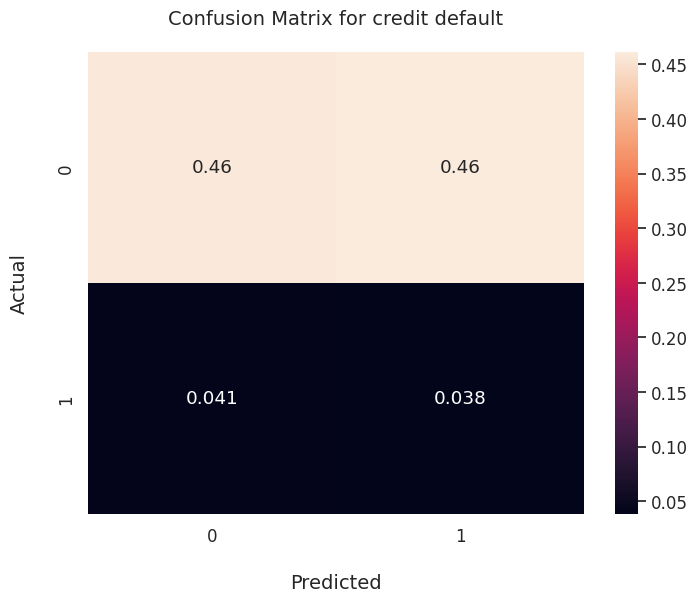

              precision    recall  f1-score   support

           0       0.92      0.50      0.65      6371
           1       0.08      0.48      0.13       549

    accuracy                           0.50      6920
   macro avg       0.50      0.49      0.39      6920
weighted avg       0.85      0.50      0.61      6920

custom score train :  2.75
custom score test :  0.8732658959537573
###################################################################################
[LightGBM] [Info] Number of positive: 23781, number of negative: 23781
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.521522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70629
[LightGBM] [Info] Number of data points in the train set: 47562, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

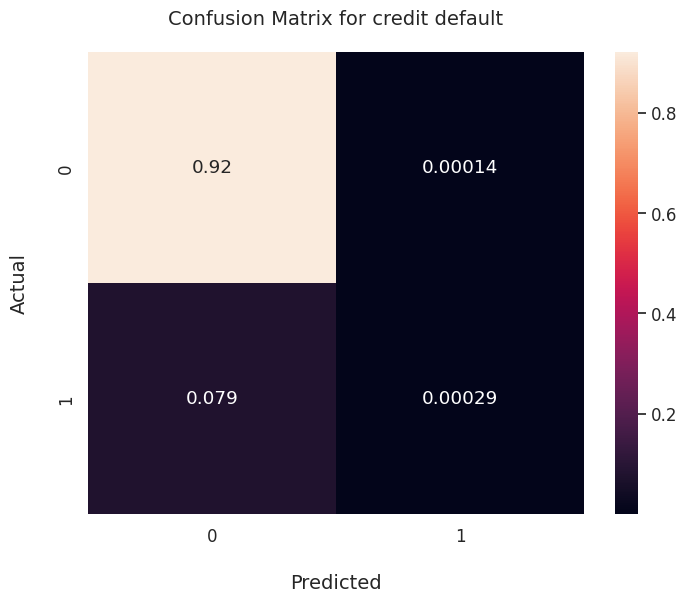

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      6371
           1       0.67      0.00      0.01       549

    accuracy                           0.92      6920
   macro avg       0.79      0.50      0.48      6920
weighted avg       0.90      0.92      0.88      6920

custom score train :  0.44
custom score test :  0.7906069364161848
###################################################################################
[LightGBM] [Info] Number of positive: 23780, number of negative: 23781
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.998158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70533
[LightGBM] [Info] Number of data points in the train set: 47561, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499989 -> initscore=-0.000042
[LightGBM] [Info] Start training from score -0.000042
[LightGBM] [Warning] No fu

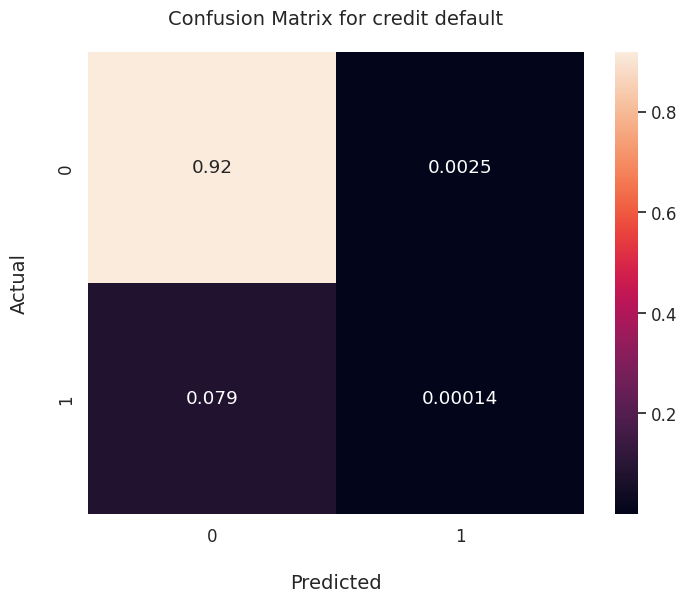

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      6371
           1       0.06      0.00      0.00       549

    accuracy                           0.92      6920
   macro avg       0.49      0.50      0.48      6920
weighted avg       0.85      0.92      0.88      6920

custom score train :  0.33
custom score test :  0.7943641618497109
###################################################################################
model :  LogisticRegression(C=78.47599703514607, max_iter=4272)
fp :  0.25549132947976877 
tn :  0.03497109826589596


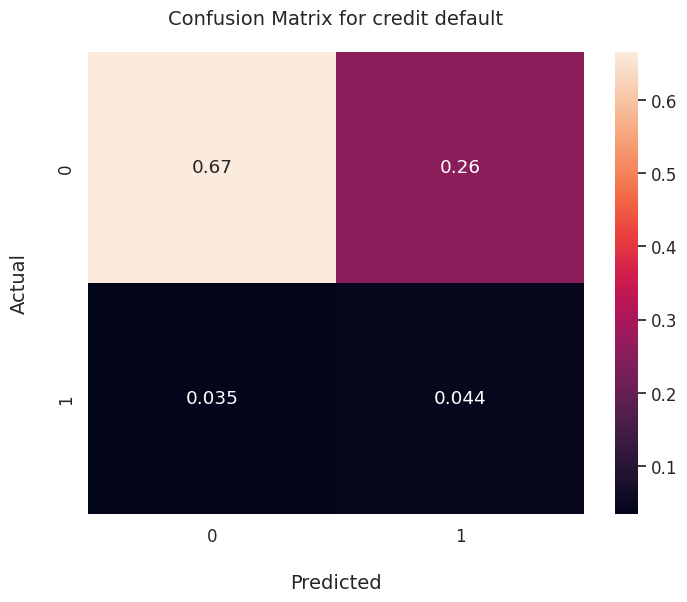

              precision    recall  f1-score   support

           0       0.95      0.72      0.82      6371
           1       0.15      0.56      0.23       549

    accuracy                           0.71      6920
   macro avg       0.55      0.64      0.53      6920
weighted avg       0.89      0.71      0.77      6920

custom score train :  1.28
custom score test :  0.6052023121387283
###################################################################################


In [74]:
# Train/fit models and display best model evaluations, graphs and scores
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score

result_table = []


for (name, est) in (estimators):
    # Cross validation with RandomizedSearchCV

    score = application_bureau_prev.shape[0]
    model=[]
    Names=[]
    
    # paramètre CV
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)    # n_splits=10, n_repeats=3
    
    # Instance RandomizedSearchCV
    clf = RandomizedSearchCV(est, 
                                param_distributions=params_list_RndSearchCV[name],
                                n_iter=10, 
                                cv=cv, 
                                scoring=custom_scorer, 
                                n_jobs=-1,    
                                random_state=42,
                                refit="custom_scorer"
                                )  

    # Fit
    clf.fit(X_train_s_final, y_train_s)
    
   
    # Predict
    y_pred = clf.best_estimator_.predict(X_test_s_final)

    # Display results
    print("model : ", clf.best_estimator_)
    confmat(y_test_s, y_pred)
    print(classification_report (y_test_s, y_pred))
    print("custom score train : ",(-clf.best_score_).round(2))
    print("custom score test : ",cost_function(y_test_s, y_pred))
    print('###################################################################################')
        
    fpr, tpr, threshold = det_curve(y_test_s, y_pred)
    result_table.append({'models':clf.best_estimator_, 
                                        #'fpr':fpr,
                                        #'tpr':tpr,
                                        'auc':roc_auc_score(y_test_s, y_pred),
                                        'F1':f1_score(y_test_s, y_pred), 
                                        'Custom Cost train':(-clf.best_score_).round(2),
                                        'Custom Cost test' :cost_function(y_test_s, y_pred),
                                        'Accuracy':accuracy_score(y_test_s, y_pred)})

In [75]:
result_table = pd.DataFrame(result_table)
result_table

,models,auc,F1,Custom Cost train,Custom Cost test,Accuracy
0,DummyClassifier(strategy='stratified'),0.489849,0.131802,2.75,0.873266,0.497399
1,LGBMClassifier(learning_rate=0.034973279224012...,0.501743,0.007246,0.44,0.790607,0.920809
2,"(DecisionTreeClassifier(max_features=1, random...",0.499577,0.003527,0.33,0.794364,0.918353
3,"LogisticRegression(C=78.47599703514607, max_it...",0.640846,0.233994,1.28,0.605202,0.709538


In [76]:
result_table.to_csv("results.csv",index=False)

In [77]:
# Enregistrement du meilleur modèle (score maison mini)
index = np.argmin(result_table['Custom Cost test'])   
       
Model_name = result_table.iloc[index, 0]
Model_name_AUC = result_table.iloc[index, 3]
Model_name_Acc = result_table.iloc[index, -1]
Model_name_Custom = result_table.iloc[index, 5]
Model_name

LogisticRegression(C=78.47599703514607, max_iter=4272)

In [86]:
# Best Threshold and cost with best model
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
model = Model_name
# entraînez votre modèle de classification binaire
model.fit(X_train_s_final, y_train_s)

# obtenez les scores de probabilité pour votre ensemble de données de validation ou de test
y_scores = model.predict_proba(X_test_s_final)[:, 1]
range_th = np.linspace(0, 1, 101)
range_co = []
# appliquez différents seuils de classification aux scores de probabilité
for threshold in range_th:
    y_pred = (y_scores >= threshold).astype(int)

    # évaluez la performance de chaque prédiction binaire en utilisant des mesures d'évaluation
    range_co.append(cost_function(y_test_s, y_pred))
    #range_co_df=pd.DataFrame(range_co)
    best_th = range_th[np.argmin(range_co)]
print('Best model : ', model,'\nBest Cost on test sample): ', min(range_co),'\nBest Threshold : ',best_th)

Best model :  LogisticRegression(C=78.47599703514607, max_iter=4272) 
Best Cost on test sample):  0.6004335260115606 
Best Threshold :  0.6


0.0

### Feature importance

In [103]:
# La liste des variables hors target
feature_names = X_train_s_final.columns.tolist()
#feature_names.remove('TARGET')

In [146]:
feature_names_all = X_train_final.columns.tolist()

In [88]:
# Le meilleur modèle entraîné
Best_clf = Model_name
Best_clf.fit(X_train_s_final, y_train_s)

LogisticRegression(C=78.47599703514607, max_iter=4272)

In [151]:
X = df_.values

In [153]:
X.shape

(307511, 420)

In [96]:
Model_L = result_table.iloc[1, 0]
Model_L

LGBMClassifier(learning_rate=0.03497327922401265, max_depth=4,
               min_child_weight=40, n_estimators=300, num_leaves=12)

In [144]:
Model_L.fit(X_train_final, y_train)

[LightGBM] [Info] Number of positive: 17377, number of negative: 197880
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.653249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31527
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 395
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080727 -> initscore=-2.432513
[LightGBM] [Info] Start training from score -2.432513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMClassifier(learning_rate=0.03497327922401265, max_depth=4,
               min_child_weight=40, n_estimators=300, num_leaves=12)

In [145]:
Model_L.feature_importances_.shape

(420,)

In [147]:
len(feature_names_all)

420

In [142]:
#traitement des colonnes dont le nom est de type "JSON"
import re
X_train_final=X_train_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_val_final=X_val_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_final=X_test_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [150]:
X.shape

(307511, 488)

[LightGBM] [Info] Number of positive: 17377, number of negative: 197880
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.617229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31527
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 395
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080727 -> initscore=-2.432513
[LightGBM] [Info] Start training from score -2.432513


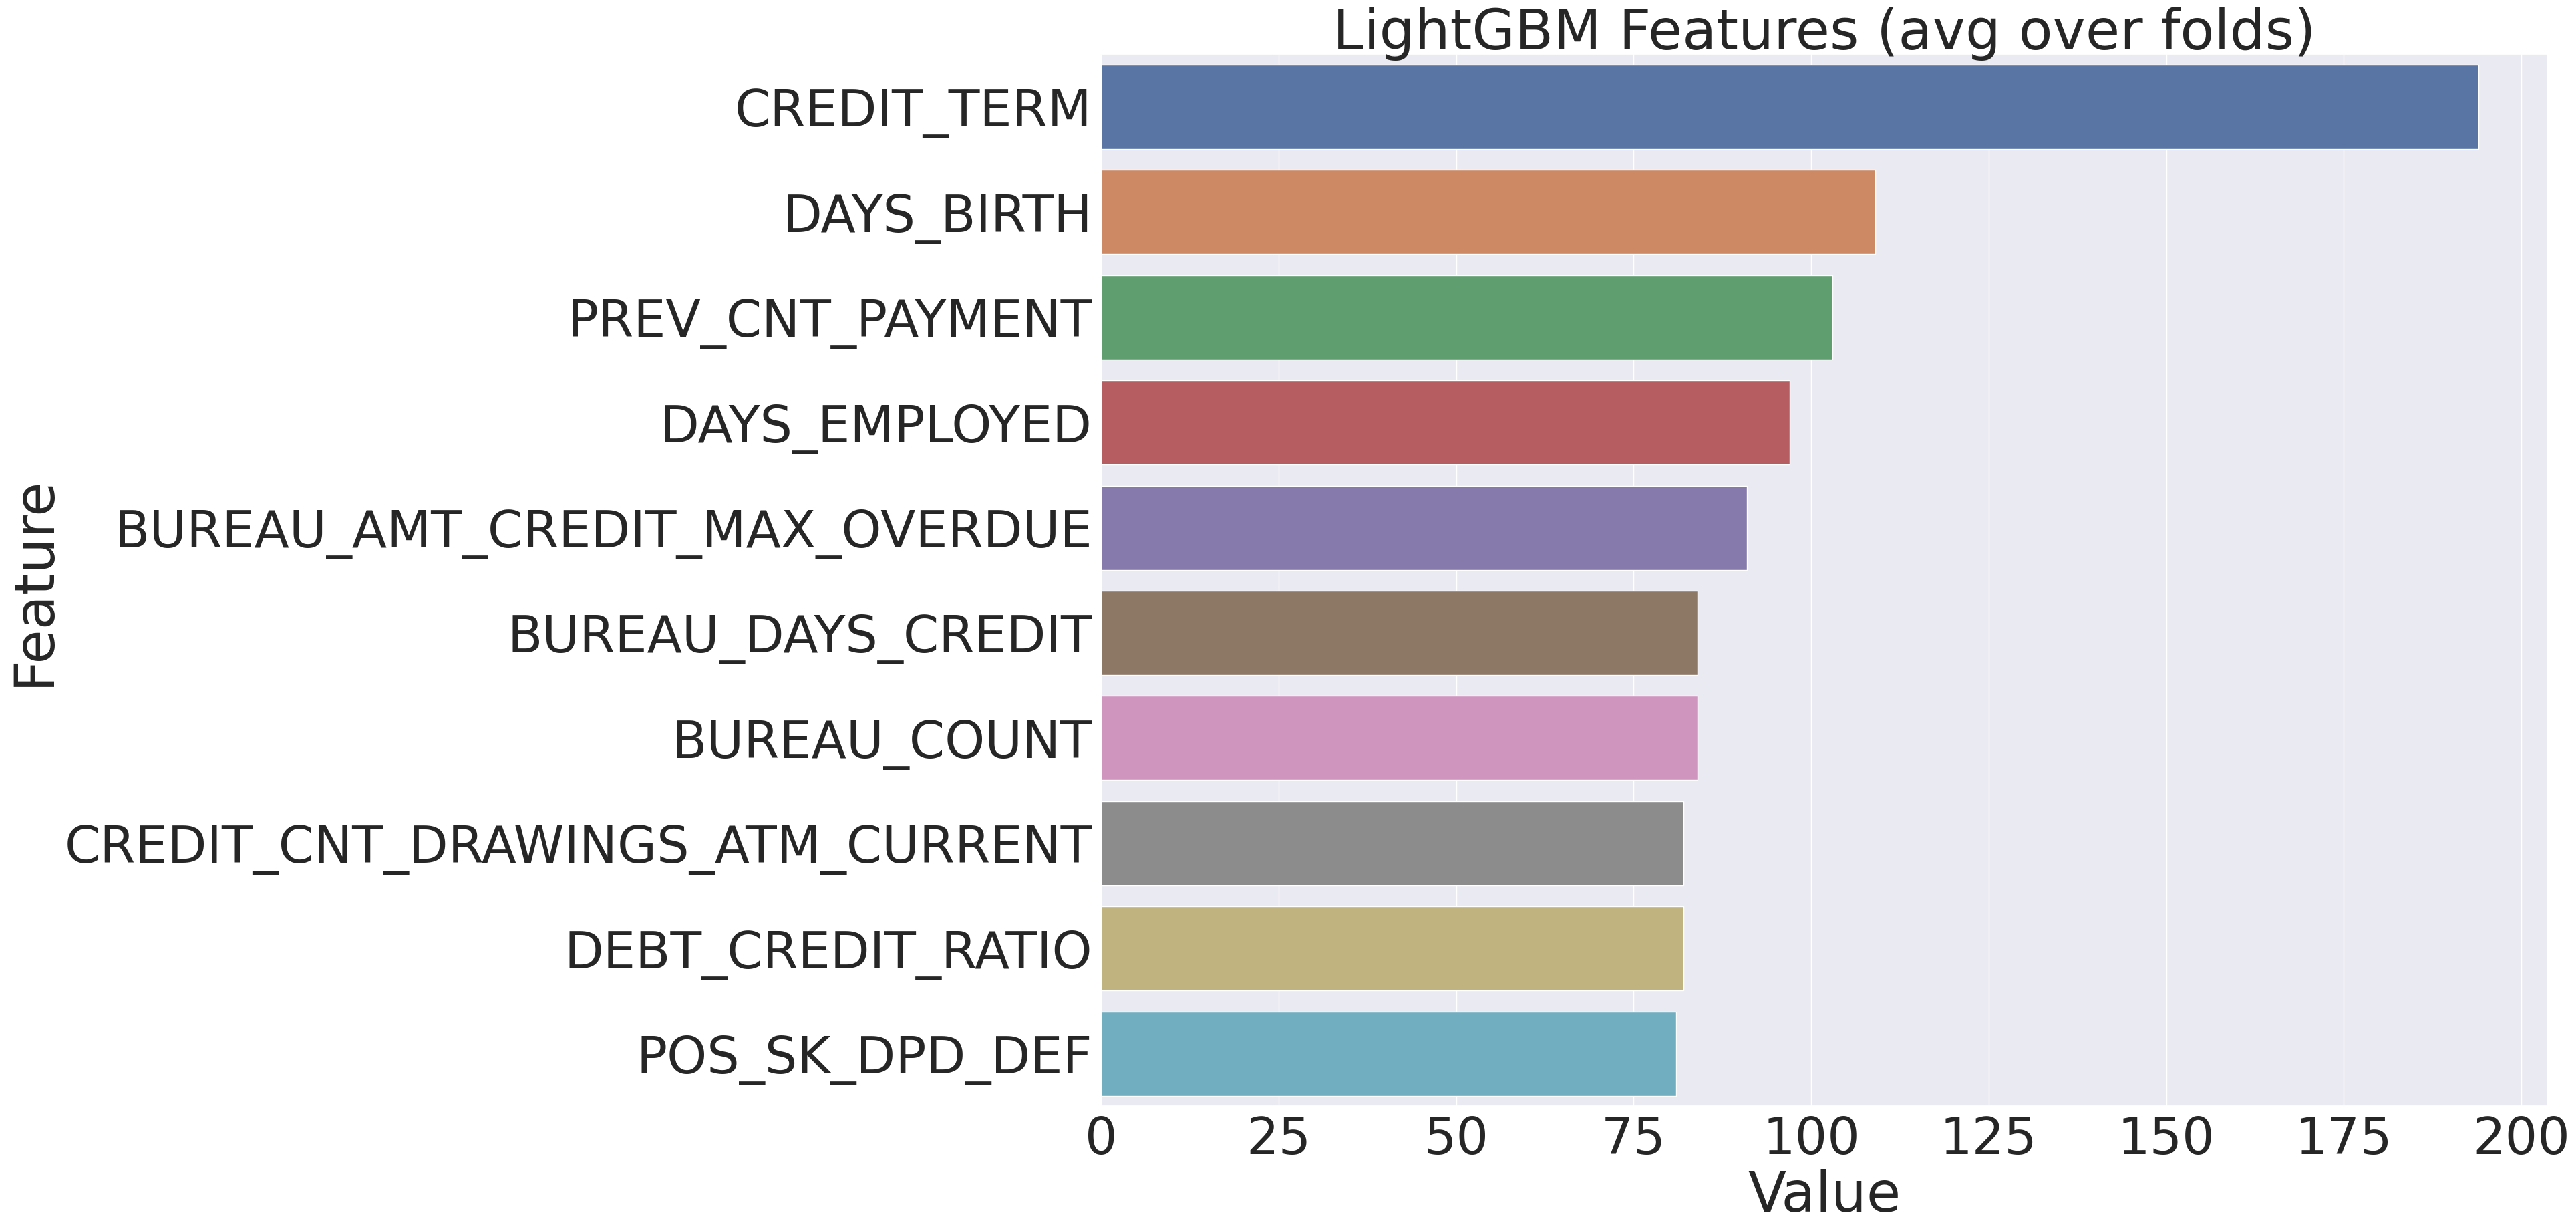

In [155]:
# La visualisation des important feature pour un LGBM
feature_imp = pd.DataFrame({'Value':Model_L.feature_importances_,'Feature':feature_names_all})

#if str(Model_name).startswith('LGBM') :
import lightgbm

from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier()

lgbm_model.fit(X_train_final, y_train)

y_pred = lgbm_model.predict(X_test_final)


# Vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plotImp(model, X, num = 20, fig_size = (40, 20)):
        feature_imp = pd.DataFrame({'Value':Model_L.feature_importances_,'Feature':feature_names_all})
        plt.figure(figsize=fig_size)
        sns.set(font_scale = 5)
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                            ascending=False)[0:num])
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.savefig('lgbm_importances-01.png')
        plt.show()

plotImp(lgbm_model,X_train_final,num = 10, fig_size = (40, 20))

    

In [157]:
# Le dictionnaire des features importance du plus petit au plus grand
#feature_imp = pd.DataFrame({'Value':lgbm_model.feature_importances_,'Feature':feature_names_all})
feature_imp = pd.DataFrame({'Value':Model_L.feature_importances_,'Feature':feature_names_all})
df_imp_best = feature_imp.sort_values(by="Value",ascending=False)[0:10]

## Re-training the best model on its 10 most important features

In [158]:
# La liste des features importantes
imp_feat = df_imp_best['Feature'].unique()
imp_feat

array(['CREDIT_TERM', 'DAYS_BIRTH', 'PREV_CNT_PAYMENT', 'DAYS_EMPLOYED',
       'BUREAU_AMT_CREDIT_MAX_OVERDUE', 'BUREAU_DAYS_CREDIT',
       'BUREAU_COUNT', 'CREDIT_CNT_DRAWINGS_ATM_CURRENT',
       'DEBT_CREDIT_RATIO', 'POS_SK_DPD_DEF'], dtype=object)

In [162]:
 application_bureau_prev.shape

(307511, 421)

In [164]:
# Le dataset réduit aux features importantes
feat = imp_feat.tolist()
df_i = df_.loc[:,feat]
X_i = df_i.values
y_i = y

In [166]:
len(X_i)

307511

In [167]:
# Split du dataset
X_tr, X_te, y_tr, y_te = train_test_split(X_i,y_i,test_size=0.2, random_state=42)

In [168]:
# Entraînement du modéle
Model_L.fit(X_tr, y_tr)

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

LGBMClassifier(learning_rate=0.03497327922401265, max_depth=4,
               min_child_weight=40, n_estimators=300, num_leaves=12)

In [170]:
# Vérification du score
y_te_pred = Model_L.predict(X_te)
y_te_pred = (y_te_pred >= best_th)
tn, fp, fn, tp = confusion_matrix(y_te, y_te_pred, normalize='all').ravel()

# Test scoring
print('Test results: ')
print('Cost (10fn+fp): {:.2f}'.format(10*fn + fp))
print('AUC: %.2f' % roc_auc_score(y_test, y_pred))
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Test results: 
Cost (10fn+fp): 0.80
AUC: 0.51
Accuracy: 0.92


## Part 5 : Recording data, model and experiment

In [172]:
!pip install mlflow --quiet
!pip install pyngrok --quiet
import mlflow
from mlflow.models import infer_signature

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.10.2 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.


In [173]:
from mlflow.models.signature import infer_signature

In [177]:
signature=infer_signature(X_tr,y_tr)

In [178]:
import mlflow.sklearn

In [181]:
mlflow.sklearn.save_model(Model_L,'mlflow_model_1',signature=signature)

2025/02/05 18:22:17 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: mlflow_model_1/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.2.2', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 


## Régression logisqtique

Avec SMOTE (Pipeline)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
model_Log_S = Pipeline([
        ('sampling', SMOTE()),
        ('classification', LogisticRegression(C = 0.0001))
    ])

# Train on the training data
model_Log_S.fit(X_train_final, y_train)

#grid_Log_S = GridSearchCV(model_Log_S, {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]},cv=10)
#grid_Log_S.fit(X_train_final, y_train)

#print("tuned hpyerparameters :(best parameters) ",grid_Log_S.best_params_)
#print("accuracy :",grid_Log_S.best_score_)

In [ ]:
y_pred_Log_S_val=model_Log_S.predict(X_val_num_final)

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
print(classification_report(y_val,y_pred_Log_S_val))

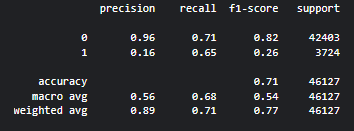

plot_confusion_matrix(y_val,y_pred_Log_S_val)

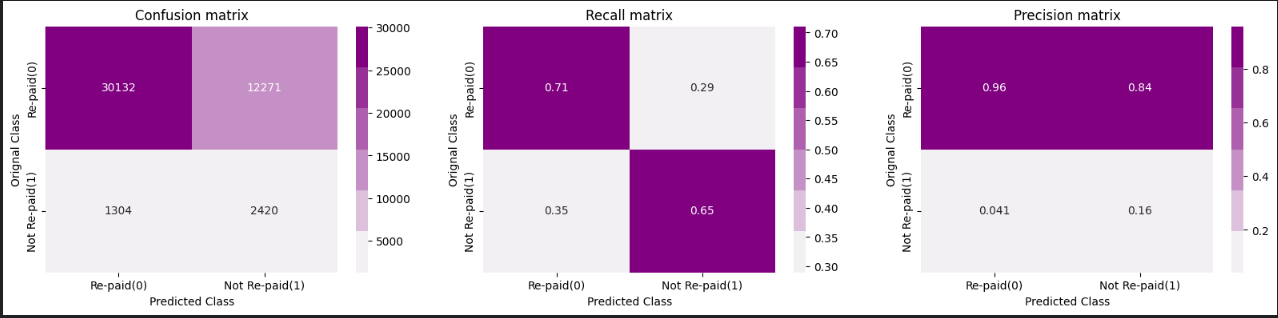

In [ ]:
y_predprob_Log_S_val=model_Log_S.predict_proba(X_val_num_final)[:,1]
y_predprob_Log_S_val[:10]

In [ ]:
####
fpr,tpr,threshold = roc_curve(y_val,y_predprob_Log_S_val)
auc_Log_S_val=roc_auc_score(y_val,y_predprob_Log_S_val)
auc_Log_S_val

0.7477895654840505

####
plt.plot(fpr,tpr,marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig('ROC_curve.png')

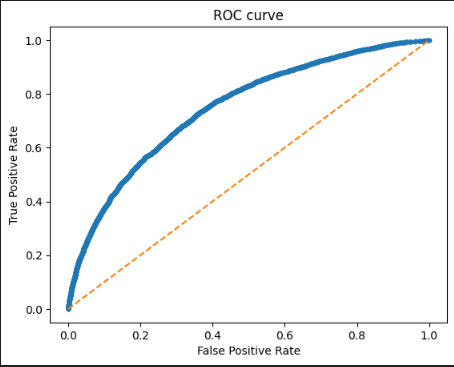

In [ ]:
y_pred_Log_S=model_Log_S.predict(X_test_final)

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
print(classification_report(y_test,y_pred_Log_S))

#log_reg_S = LogisticRegression(meilleurs paramètres)
#y_pred_Log_S=log_reg_S.predict(X_test_final)


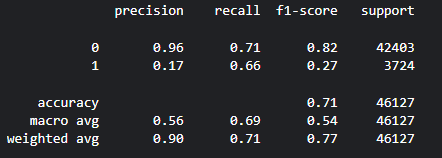

In [ ]:
plot_confusion_matrix(y_test, y_pred_Log_S)

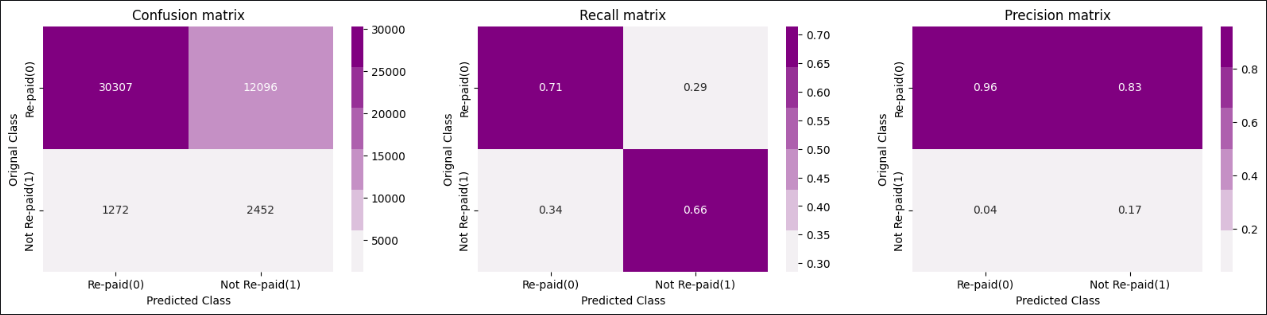

y_predprob_Log_S=model_Log_S.predict_proba(X_test_final)[:,1]
y_predprob_Log_S[:10]

####
fpr,tpr,threshold = roc_curve(y_test,y_predprob_Log_S)
auc_Log_S=roc_auc_score(y_test,y_predprob_Log_S)
auc_Log_S

0.751816118233127

####
plt.plot(fpr,tpr,marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig('ROC_curve.png')

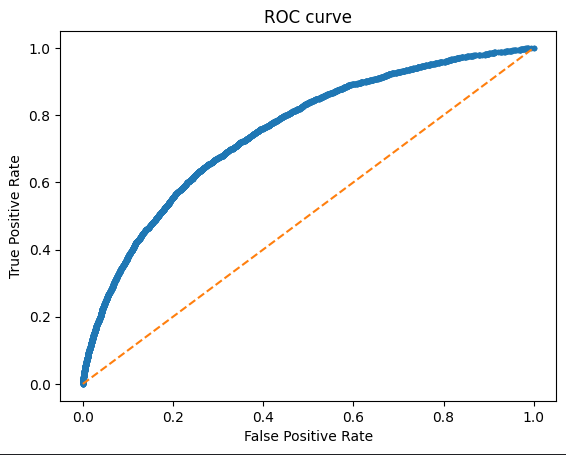

### II. tentative de recalcul en changeant le seuil de probabilité

In [ ]:
def calculate_threshold(y_true, y_prob, threshold):
    # Convertir les probabilités en prédictions en fonction du seuil 
    y_pred = (y_prob >= threshold).astype(int) 

    # Calculer la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() 
    
    # Coûts
    cost_fp = 1 # Coût des faux positifs
    cost_fn = 10 # Coût des faux négatifs
    total_cost = fp * cost_fp + fn * cost_fn 
    return total_cost

# Prédire les probabilités sur les données de validation 
y_prob = model_Log_S.predict_proba(X_train_final)[:, 1] # Probabilités de la classe positive 

# Explorer les seuils de probabilité
thresholds = np.arange(0.0, 1.0, 0.01)
scores_metier = [calculate_threshold(y_train, y_prob, t) for t in thresholds]

# Trouver le seuil avec le meilleur (le plus bas) score métier
best_threshold = thresholds[np.argmin(scores_metier)] 
best_score_metier = min(scores_metier) 
print(f"Meilleur seuil : {best_threshold}") 
print(f"Score métier optimal : {best_score_metier}")


In [ ]:
# Score métier
def score_metier(y_true, y_pred): 
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost_fp = 1 # Cout faux positif 
    cost_fn = 10 # Cout faux negatif 
    total_cost = fp * cost_fp + fn * cost_fn
    return total_cost


In [ ]:
#score_metier(y_train, y_prob)

Sans SMOTE

####
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(X_train_final, y_train)

Validation

y_pred_Log_val=log_reg.predict(X_val_num_final)

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
print(classification_report(y_val,y_pred_Log_val))

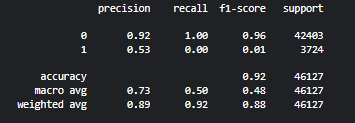

plot_confusion_matrix(y_val,y_pred_Log_val)

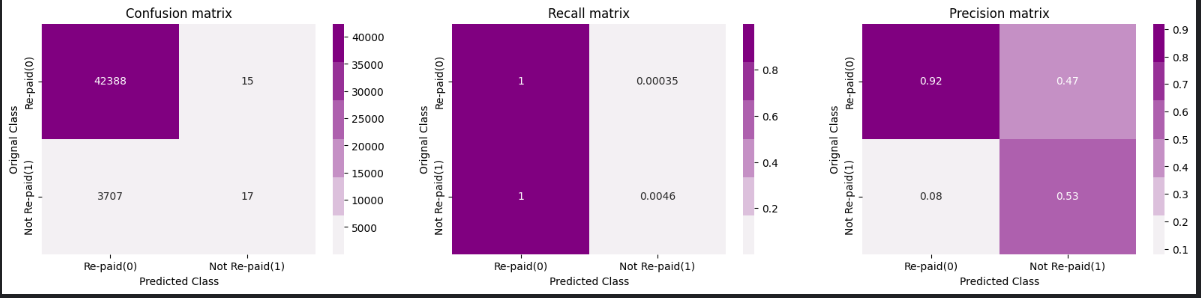

y_predprob_Log_val=log_reg.predict_proba(X_val_num_final)[:,1]
y_predprob_Log_val[:10]

####
fpr,tpr,threshold = roc_curve(y_val,y_predprob_Log_val)
auc_Log_val=roc_auc_score(y_val,y_predprob_Log_val)
auc_Log_val

0.7586007064889341

Test

####
y_pred=log_reg.predict(X_test_final)


####
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
print(classification_report(y_test,y_pred))

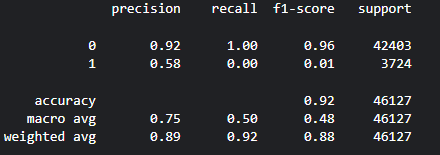

plot_confusion_matrix(y_test, y_pred)

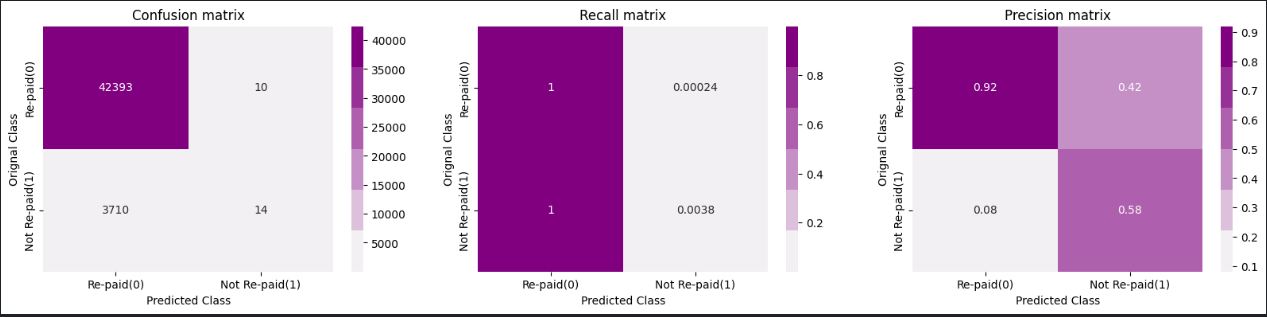

####
y_predprob_Log=log_reg.predict_proba(X_test_final)[:,1]
y_predprob_Log[:10]

####
fpr,tpr,threshold = roc_curve(y_test,y_predprob_Log)
auc_Log=roc_auc_score(y_test,y_predprob_Log)


####
plt.plot(fpr,tpr,marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig('ROC_curve.png')

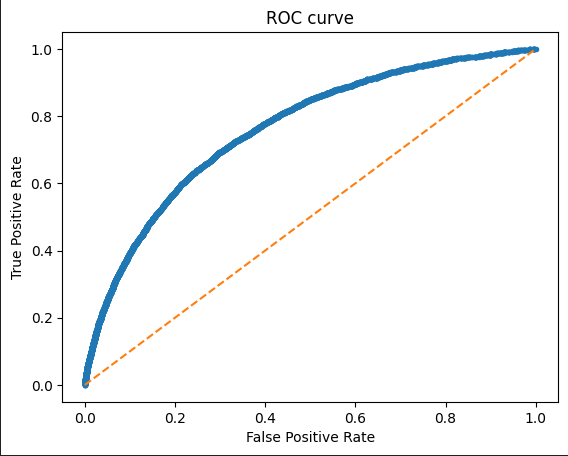

####
#auc_Log= auc(fpr,tpr)
auc_Log

0.7620888027677145

Accuracy: 0.92
AUC: 0.76 ce qui est trsè correct

## Light GBM Classifier

####
#traitement des colonnes dont le nom est de type "JSON"
import re
X_train_final=X_train_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_val_final=X_val_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_final=X_test_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
import re
X_train_s_final=X_train_s_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_val_s_final=X_val_s_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_s_final=X_test_s_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
model_sk_s = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=10, max_depth=3, learning_rate=0.01, n_estimators= 200, 
                 class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)
train_features_s, valid_features_s, train_y_s, valid_y_s = train_test_split(X_train_s_final, y_train_s, test_size = 0.05, random_state = 42)

In [ ]:
model_sk_s.fit(train_features_s, train_y_s, callbacks=[lgb.early_stopping(stopping_rounds=100)], eval_set = [(valid_features_s, valid_y_s)], eval_metric = 'auc')

####
model_sk = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000, 
                 class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)
train_features, valid_features, train_y, valid_y = train_test_split(X_train_s_final, y_train, test_size = 0.15, random_state = 42)
model_sk.fit(train_features, train_y, callbacks=[lgb.early_stopping(stopping_rounds=100)], eval_set = [(valid_features, valid_y)], eval_metric = 'auc')

Early stopping, best iteration is:
[1593]	valid_0's auc: 0.780477	valid_0's binary_logloss: 0.518038

Test

In [ ]:
y_pred_LGBM_s=model_sk_s.predict(X_test_s_final)

In [ ]:
y_pred_LGBM_s=model_sk_s.predict(X_test_s_final,num_iteration=model_sk_s.best_iteration_)

In [ ]:
####
y_predprob_LGBM_s=model_sk_s.predict_proba(X_test_s_final,num_iteration=model_sk_s.best_iteration_)[:, 1]

In [ ]:
####
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
fpr,tpr,threshold = roc_curve(y_test,y_pred_LGBM_s)

In [ ]:
####
auc_LGBM=roc_auc_score(y_test,y_predprob_LGBM_s)
auc_LGBM

0.7842619851416488

In [ ]:
print(classification_report(y_test,y_pred_LGBM_s))

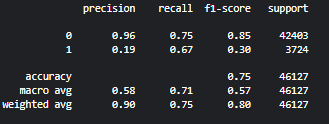

####
plt.plot(fpr,tpr,marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig('ROC_curve.png')

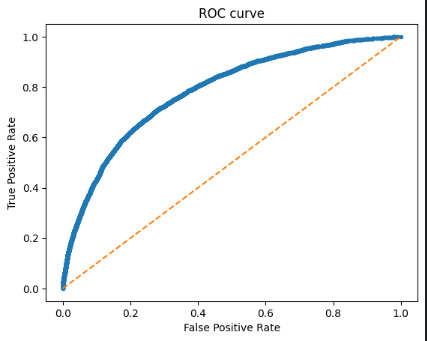

In [ ]:
####
feature_imp_s = pd.DataFrame(sorted(zip(model_sk_s.feature_importances_, X_train_s_final.columns)), columns=['Value','Feature'])
features_df_s = feature_imp_s.sort_values(by="Value", ascending=False)
selected_features_s = list(features_df_s[features_df_s['Value']>=10]['Feature'])
# Saving the selected features into pickle file
with open('select_features.txt','wb') as fp:
    pickle.dump(selected_features_s, fp)
print('The no. of features selected:',len(selected_features_s))

feature_imp_s = pd.DataFrame(sorted(zip(model_sk_s.feature_importances_, X_train_s_final.columns)), columns=['Value','Feature'])
features_df_s = feature_imp_s.sort_values(by="Value", ascending=False)
for i in [10,20,30,40,50]:
    selected_features_s = list(features_df_s[features_df_s['Value']>=i]['Feature'])
    print('The no. of features selected:',len(selected_features_s))
    y_pred_LGBM_s=model_sk_s.predict(X_test_s_final[selected_features_s])

####
# Display/plot feature importance
plt.figure(figsize=(8, 10))
sns.barplot(x="Value", y="Feature", data=features_df_s[features_df_s['Value']>=200])
plt.title('LightGBM Features')
plt.tight_layout()
plt.savefig('lgbm_importances01.png')

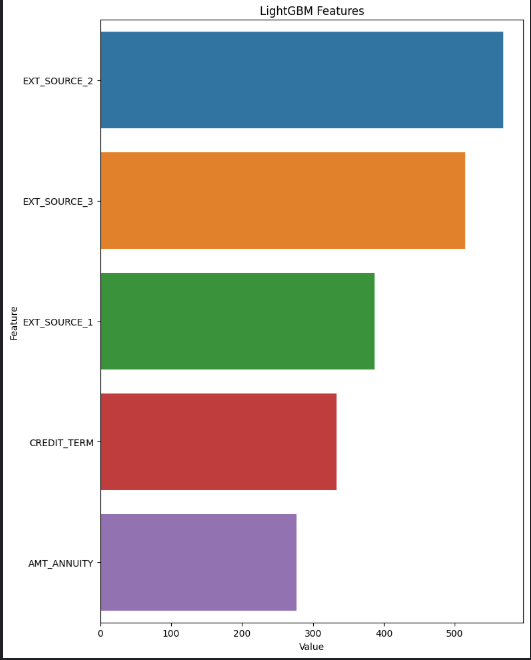

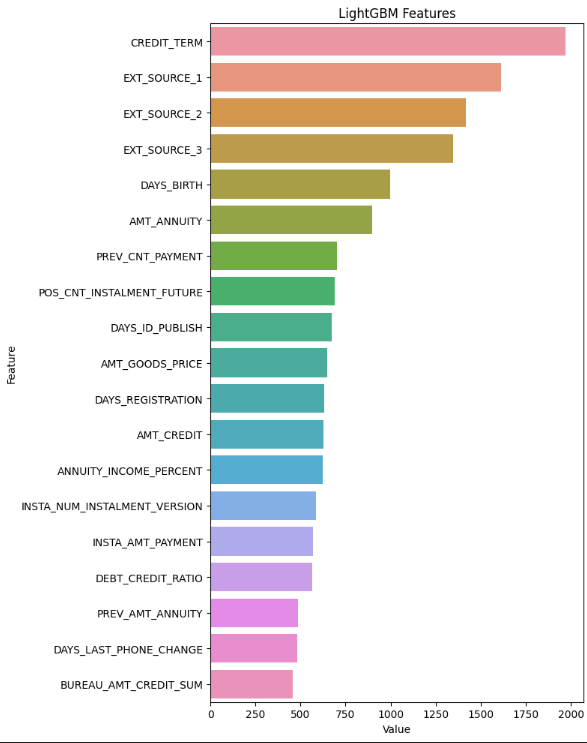

### SHAP feature importance

In [ ]:
import shap
from lime.lime_tabular import LimeTabularExplainer
import xgboost
import seaborn as sns



explainer = shap.KernelExplainer(model_sk_s.predict_proba,  X_train_s_final,link='logit')
shap_values = explainer.shap_values(X_test_s_final,  l1_reg="aic")
elapsed_time = time.time() - start_time
# explain first sample from test data
#print("Kernel Explainer SHAP run time", round(elapsed_time,3) , " seconds. ", current_model["name"])
#print("SHAP expected value", explainer.expected_value)
#print("Model mean value", model_sk.predict_proba(X_train_final).mean(axis=0))
#print("Model prediction for test data", clf.predict_proba(X_test_final))
#shap.initjs()
#pred_ind = 0
#shap.force_plot(explainer.expected_value[1], shap_values[1][0], subsampled_test_data[0], feature_names=X_train.columns)


#shap.initjs()
import shap
shap.summary_plot(shap_values, X_test_s_final, feature_names=X_train_s_final.columns, max_display=10)

feature_imp_loc_s = pd.DataFrame(sorted(zip(shap_values, X_train_s_final.columns)), columns=['Value','Feature'])
features_df_loc_s = feature_imp_loc_s.sort_values(by="Value", ascending=False)
selected_features_loc_s = list(features_df_loc_s[features_df_loc_s['Value']>=50]['Feature'])
# Saving the selected features into pickle file
with open('select_features.txt','wb') as fp:
    pickle.dump(selected_features_s, fp)
print('The no. of features selected:',len(selected_features_s))

LIME

In [ ]:
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
lime_explainer = LimeTabularExplainer(X_train_s_final.values,
                                      feature_names=X_train_s_final.columns.values.tolist(),
                                      
                                      mode="classification" )

In [ ]:
# Choose the 5th instance and use it to predict the results
for j in [5,100,400]:
    exp = lime_explainer.explain_instance(X_test_s_final.values[j], model_sk_s.predict_proba, num_features=10)
    exp.show_in_notebook(show_table=True)

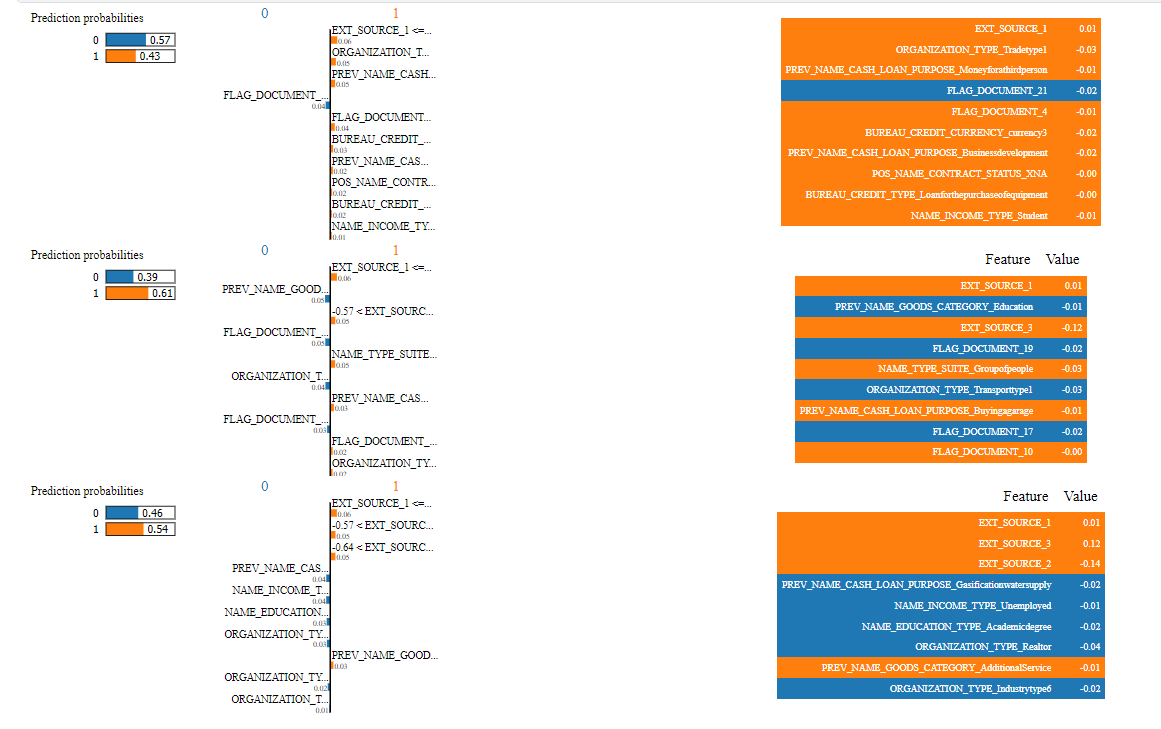

In [ ]:
exp.show_in_notebook(show_table=True)

In [ ]:
fig=exp.as_pyplot_figure

In [ ]:
#joblib.dump()

### LIGHT GBM avec SMOTE

import re
X_train_s_final=X_train_s_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_val_s_final=X_val_s_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_s_final=X_test_s_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

On réduit le modèles aux principales features

In [ ]:
model_sk = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000, 
                 class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)
train_features_s_sf, valid_features_s_sf, train_y_s, valid_y_s = train_test_split(X_train_s_final[selected_features_s], y_train_s, test_size = 0.05, random_state = 42)

model_sk = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000, 
                 class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)
train_features_s, valid_features_s, train_y_s, valid_y_s = train_test_split(X_train_s_final, y_train_s, test_size = 0.15, random_state = 42)

#calcul sans selection des features
from sklearn.model_selection import KFold
from imblearn.pipeline import make_pipeline, Pipeline
kf = KFold(n_splits=5, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0)
#model_LGBM_S = Pipeline([('sampling', SMOTE()),('classification', model_sk) ])
rs_parameters = {
    'lgbmclassifier__learning_rate': [0.005,0.01,0.001,0.05],
    'lgbmclassifier__n_estimators': [200,500,1000,2000],
    'lgbmclassifier__num_leaves': [6,8,12]
    }

smp_pipeline = make_pipeline(sampler, model_sk)
grid_imba = GridSearchCV(smp_pipeline,
                         param_grid=rs_parameters,
                         cv=kf,
                         scoring='roc_auc',
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=True
                        )
grid_imba.fit(train_features_s, train_y_s)
bestimator = grid_imba.best_estimator_
ypred = bestimator.predict(X_test_final)

In [ ]:
#calcul avec selection des features
from sklearn.model_selection import KFold
from imblearn.pipeline import make_pipeline, Pipeline
kf = KFold(n_splits=5, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0)
#model_LGBM_S = Pipeline([('sampling', SMOTE()),('classification', model_sk) ])
rs_parameters = {
    'lgbmclassifier__learning_rate': [0.005,0.01,0.001,0.05],
    'lgbmclassifier__n_estimators': [200,500,1000,2000],
    'lgbmclassifier__num_leaves': [6,8,12]
    }

smp_pipeline = make_pipeline(sampler, model_sk)
grid_imba = GridSearchCV(smp_pipeline,
                         param_grid=rs_parameters,
                         cv=kf,
                         scoring='roc_auc',
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=True
                        )
grid_imba.fit(train_features_s_sf, train_y_s)
bestimator = grid_imba.best_estimator_
ypred = bestimator.predict(X_test_final[selected_features_s])

#sans selection des features
ypred = bestimator.predict(X_test_final)

In [ ]:
grid_imba.best_params_

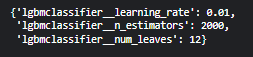

In [ ]:
grid_imba.best_score_

0.7449885925998653

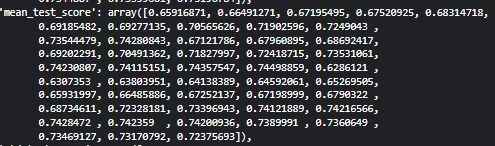

###
#y_predprob_LGBM_S=bestimator.predict_proba(X_test_final,num_iteration=grid_imba.best_iteration_)[:, 1]
y_predprob_LGBM_S=bestimator.predict_proba(X_test_final)[:, 1]


In [ ]:
#Refaire le calucl avec la nouvelles proba

# Prédire les probabilités sur les données de validation 
y_prob = bestimator.predict_proba(X_train_s_final[selected_features_s)[:, 1] # Probabilités de la classe positive 

# Explorer les seuils de probabilité
thresholds = np.arange(0.0, 1.0, 0.01)
scores_metier = [calculate_threshold(y_train_s, y_prob, t) for t in thresholds]

# Trouver le seuil avec le meilleur (le plus bas) score métier
best_threshold = thresholds[np.argmin(scores_metier)] 
best_score_metier = min(scores_metier) 
print(f"Meilleur seuil : {best_threshold}") 
print(f"Score métier optimal : {best_score_metier}")


In [ ]:
calculate_threshold(y_test_s, y_prob, 0.53)

####
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
fpr,tpr,threshold = roc_curve(y_test,ypred)

In [ ]:
#avec selection des features et seuil optimisé
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc 
fpr,tpr,threshold = roc_curve(y_test_s,ypred)

auc_LGBM_S=roc_auc_score(y_test,y_predprob_LGBM_S)
auc_LGBM_S

0.6484952336910074

In [ ]:
#avec selection des features et seuil optimisé
auc_LGBM_S_opt=roc_auc_score(y_test_s,y_prob)
auc_LGBM_S_opt

print(classification_report(y_test,y_pred))

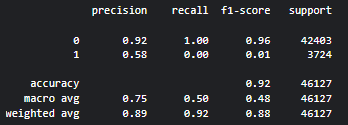

In [ ]:
#avec selection des features et seuil optimisé
print(classification_report(y_test_s,ypred))

####
plt.plot(fpr,tpr,marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig('ROC_curve.png')

####
feature_imp_S = pd.DataFrame(sorted(zip(bestimator.feature_importances_, X_train_final.columns)), columns=['Value','Feature'])
features_df_S = feature_imp_S.sort_values(by="Value", ascending=False)
selected_features_S = list(features_df_S[features_df_S['Value']>=50]['Feature'])
# Saving the selected features into pickle file
with open('select_features_S.txt','wb') as fp:
    pickle.dump(selected_features_S, fp)
print('The no. of features selected:',len(selected_features_S))

In [ ]:
#sauvegarde du model
joblib.dump(bestimator)

In [ ]:
signature=infer_signature(X_train_s, y_train)

####
# Display/plot feature importance
plt.figure(figsize=(8, 10))
sns.barplot(x="Value", y="Feature", data=features_df_S[features_df_S['Value']>=450])
plt.title('LightGBM Features with SMOTE')
plt.tight_layout()
plt.savefig('lgbm_importances02.png')

## Random Forest en utlisant la selection de feature

### Sans traitement des classes non équilibrées

In [ ]:
####
#alpha = [200,500,1000,2000]
#max_depth = [7, 10]
#cv_auc_score = []
#for i in alpha:
    #for j in max_depth:
        #clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j,class_weight='balanced',
                                     #random_state=42, n_jobs=-1)
        #clf.fit(X_train_final[selected_features], y_train)
        #sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        #sig_clf.fit(X_train_final[selected_features], y_train)
        #y_pred_prob_RF = sig_clf.predict_proba(X_val_final[selected_features])[:,1]
        #cv_auc_score.append(roc_auc_score(y_val,y_pred_prob_RF))
        #print('For n_estimators {0}, max_depth {1} cross validation AUC score {2}'.
              #format(i,j,roc_auc_score(y_val,y_pred_prob_RF)))

Le code au dessus donne les résultats suivants:


* For n_estimators 200, max_depth 7 cross validation AUC score 0.7446352442028996
* For n_estimators 200, max_depth 10 cross validation AUC score 0.7497989535375527
* For n_estimators 500, max_depth 7 cross validation AUC score 0.7453515501976039
* For n_estimators 500, max_depth 10 cross validation AUC score 0.7502633165939635
* For n_estimators 1000, max_depth 7 cross validation AUC score 0.7458400031126833
* For n_estimators 1000, max_depth 10 cross validation AUC score 0.7508213096609985
* For n_estimators 2000, max_depth 7 cross validation AUC score 0.7460814589831652For n_estimators 2000, max_depth 10 cross validation AUC score 0.7509242805079885


On retient alpha = 2000 et max_depth = 10

In [ ]:
rf = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=10,
                            class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_final[selected_features], y_train)

In [ ]:
y_pred_prob_RF_opt_train = rf.predict_proba(X_train_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Train AUC score is {2}'.format(2000,10,roc_auc_score(y_train,y_pred_prob_RF_opt_train)))
y_pred_prob_RF_opt_val = rf.predict_proba(X_val_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Validation AUC score is {2}'.format(2000,10,roc_auc_score(y_val,y_pred_prob_RF_opt_val)))
y_pred_prob_RF_opt_test = rf.predict_proba(X_test_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Test AUC score is {2}'.format(2000,10,roc_auc_score(y_test,y_pred_prob_RF_opt_test)))
y_pred_RF_final = rf.predict(X_test_final[selected_features])
print('The test AUC score is :', roc_auc_score(y_test,y_pred_RF_final))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred_RF_final))*100))


* For best n_estimators 2000 best max_depth 10, The Train AUC score is 0.8467557161909799
* For best n_estimators 2000 best max_depth 10, The Validation AUC score is 0.7513177861961969
* For best n_estimators 2000 best max_depth 10, The Test AUC score is 0.7515218850539854
* The test AUC score is : 0.6803971821147465
* The percentage of misclassified points 23.03% :


In [ ]:
plot_confusion_matrix(y_test, y_pred_RF_final)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
print(classification_report(y_test,y_pred_RF_final))

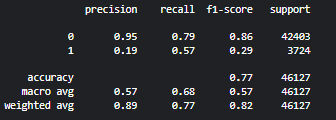

In [ ]:
auc_RF_S=roc_auc_score(y_test,y_pred_prob_RF_opt_test )
auc_RF_S

0.7515218850539854

In [ ]:
####
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
fpr,tpr,threshold = roc_curve(y_test,y_pred_RF_final)

In [ ]:
####
plt.plot(fpr,tpr,marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig('ROC_curve.png')

In [ ]:
rf_sig_clf = CalibratedClassifierCV(rf, method="sigmoid")
rf_sig_clf.fit(X_train_final[selected_features], y_train)

In [ ]:
y_pred_prob_RF_opt_train_sig = rf_sig_clf.predict_proba(X_train_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Train AUC score is {2}'.format(2000,10,roc_auc_score(y_train,y_pred_prob_RF_opt_train_sig)))
y_pred_prob_RF_opt_val_sig = rf_sig_clf.predict_proba(X_val_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Validation AUC score is {2}'.format(2000,10,roc_auc_score(y_val,y_pred_prob_RF_opt_val_sig)))
y_pred_prob_RF_opt_test_sig = rf_sig_clf.predict_proba(X_test_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Test AUC score is {2}'.format(2000,10,roc_auc_score(y_test,y_pred_prob_RF_opt_test_sig)))
y_pred_RF_final_sig = rf_sig_clf.predict(X_test_final[selected_features])
print('The test AUC score is :', roc_auc_score(y_test,y_pred_RF_final_sig))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred_RF_final_sig))*100))
#plot_confusion_matrix(y_test, y_pred_RF_final_sig)


* For best n_estimators 2000 best max_depth 10, The Train AUC score is 0.8435834508854222
* For best n_estimators 2000 best max_depth 10, The Validation AUC score is 0.7506808741442179
* For best n_estimators 2000 best max_depth 10, The Test AUC score is 0.750765707936732The test AUC score is : 0.5004545155984115
* The percentage of misclassified points 08.08% 

In [ ]:
plot_confusion_matrix(y_test, y_pred_RF_final_sig)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
print(classification_report(y_test,y_pred_RF_final_sig))

In [ ]:
fpr,tpr,threshold = roc_curve(y_test,y_pred_RF_final_sig)

In [ ]:
auc_RF_S_sig=roc_auc_score(y_test,y_pred_prob_RF_opt_test_sig)
auc_RF_S_sig

In [ ]:
####
plt.plot(fpr,tpr,marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig('ROC_curve.png')

Random Forest avec SMOTE

On réduit la taille de l'échantillon car les calculs prennent plus de 10 heures

y_s = application_bureau_prev_s.pop('TARGET').values
X_train_s, X_temp_s, y_train_s, y_temp_s = train_test_split(application_bureau_prev_s.drop(['SK_ID_CURR'],axis=1), y_s, stratify = y_s, test_size=0.3, random_state=42)
X_val_s, X_test_s, y_val_s, y_test_s = train_test_split(X_temp_s, y_temp_s, stratify = y_temp_s, test_size=0.5, random_state=42)
print('Shape of X_train:',X_train_s.shape)
print('Shape of X_val:',X_val_s.shape)
print('Shape of X_test:',X_test_s.shape)

# Seperation of columns into numeric and categorical columns
types = np.array([dt for dt in X_train_s.dtypes])
all_columns = X_train_s.columns.values
is_num = types != 'object'
num_cols = all_columns[is_num]
cat_cols = all_columns[~is_num]
# Featurization of numeric data
imputer_num = SimpleImputer(strategy='median')
X_train_s_num = imputer_num.fit_transform(X_train_s[num_cols])
X_val_s_num = imputer_num.transform(X_val_s[num_cols])
X_test_s_num = imputer_num.transform(X_test_s[num_cols])
scaler_num = StandardScaler()
X_train_s_num1 = scaler_num.fit_transform(X_train_s_num)
X_val_s_num1 = scaler_num.transform(X_val_s_num)
X_test_s_num1 = scaler_num.transform(X_test_s_num)
X_train_s_num_final = pd.DataFrame(X_train_s_num1, columns=num_cols)
X_val_s_num_final = pd.DataFrame(X_val_s_num1, columns=num_cols)
X_test_s_num_final = pd.DataFrame(X_test_s_num1, columns=num_cols)
# Featurization of categorical data
imputer_cat = SimpleImputer(strategy='constant', fill_value='MISSING')
#X_train_cat = imputer_cat.fit_transform(X_train[cat_cols])
#X_val_cat = imputer_cat.transform(X_val[cat_cols])
#X_test_cat = imputer_cat.transform(X_test[cat_cols])
#X_train_cat1= pd.DataFrame(X_train_cat, columns=cat_cols)
#X_val_cat1= pd.DataFrame(X_val_cat, columns=cat_cols)
#X_test_cat1= pd.DataFrame(X_test_cat, columns=cat_cols)
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
#X_train_cat2 = ohe.fit_transform(X_train_cat1)
#X_val_cat2 = ohe.transform(X_val_cat1)
#X_test_cat2 = ohe.transform(X_test_cat1)
#cat_cols_ohe = list(ohe.get_feature_names(input_features=cat_cols))
#X_train_cat_final = pd.DataFrame(X_train_cat2, columns = cat_cols_ohe)
#X_val_cat_final = pd.DataFrame(X_val_cat2, columns = cat_cols_ohe)
#X_test_cat_final = pd.DataFrame(X_test_cat2, columns = cat_cols_ohe)
# Final complete data
X_train_s_final = pd.concat([X_train_s_num_final], axis = 1)
X_val_s_final = pd.concat([X_val_s_num_final], axis = 1)
X_test_s_final = pd.concat([X_test_s_num_final], axis = 1)
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)

import re
X_train_s_final=X_train_s_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_val_s_final=X_val_s_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_s_final=X_test_s_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

from sklearn.model_selection import RandomizedSearchCV
alpha = [1000,2000]
max_depth = [7, 10]
cv_auc_score_RF_S_s = []


for i in alpha:
    for j in max_depth:
        
        #parameters = [{'classifier__n_estimators': i,'classifier__max_depth':j}]
        clf_RF_S_s = Pipeline(steps=[('sampling', SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto')),
                        ('classifier', RandomForestClassifier(n_estimators=i,criterion='gini',max_depth=j,class_weight='balanced',random_state=42, n_jobs=-1))
                        ])
        clf_RF_S_s.fit(X_train_s_final[selected_features], y_train_s)
       
        
        #clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j,class_weight='balanced',
                                     #random_state=42, n_jobs=-1)
       
        sig_clf_RF_S_s = CalibratedClassifierCV(clf_RF_S_s, method="sigmoid")
        sig_clf_RF_S_s.fit(X_train_s_final[selected_features], y_train_s)
        y_pred_prob_RF_S_s = sig_clf_RF_S_s.predict_proba(X_val_s_final[selected_features])[:,1]
        cv_auc_score_RF_S_s.append(roc_auc_score(y_val_s,y_pred_prob_RF_S_s))
        print('For n_estimators {0}, max_depth {1} cross validation AUC score {2}'.format(i,j,roc_auc_score(y_val_s,y_pred_prob_RF_S_s)))


* For n_estimators 200, max_depth 7 cross validation AUC score 0.6778073608222348
* For n_estimators 200, max_depth 10 cross validation AUC score 0.6886441558800799
* For n_estimators 500, max_depth 7 cross validation AUC score 0.6768362051476152
* For n_estimators 500, max_depth 10 cross validation AUC score 0.6878701456813304
* For n_estimators 1000, max_depth 7 cross validation AUC score 0.6763694229729049
* For n_estimators 1000, max_depth 7 cross validation AUC score 0.6747262084330846
* For n_estimators 1000, max_depth 10 cross validation AUC score 0.6872407732864674
* For n_estimators 2000, max_depth 7 cross validation AUC score 0.6742053332964311
* For n_estimators 2000, max_depth 10 cross validation AUC score 0.686925259122926


On retient n_estimators 200, max_depth 10  qui maximise l'AUC

#clf_RF_S.best_params_

In [ ]:
#sig_clf_RF_S.best_params_

rf_S = Pipeline(steps=[('sampling', SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto')),
                        ('classifier', RandomForestClassifier(n_estimators=200,criterion='gini',max_depth=10,class_weight='balanced',random_state=42, n_jobs=-1))
                        ])
rf_S.fit(X_train_final[selected_features], y_train)

#A retirer?
rf_sig_clf_S = CalibratedClassifierCV(rf_S, method="sigmoid")
rf_sig_clf_S.fit(X_train_final[selected_features], y_train)

#A refaure sans sig?
y_pred_prob_RF_opt_train_S = rf_sig_clf_S.predict_proba(X_train_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Train AUC score is {2}'.format(2000,10,roc_auc_score(y_train,y_pred_prob_RF_opt_train_S)))
y_pred_prob_RF_opt_val_S = rf_sig_clf_S.predict_proba(X_val_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Validation AUC score is {2}'.format(2000,10,roc_auc_score(y_val,y_pred_prob_RF_opt_val_S)))
y_pred_prob_RF_opt_test_S = rf_sig_clf_S.predict_proba(X_test_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Test AUC score is {2}'.format(2000,10,roc_auc_score(y_test,y_pred_prob_RF_opt_test_S)))
y_pred_RF_final_S = rf_sig_clf_S.predict(X_test_final[selected_features])
print('The test AUC score is :', roc_auc_score(y_test,y_pred_RF_final_S))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred_RF_final_S))*100))
plot_confusion_matrix(y_test, y_pred_RF_final_S)


* For best n_estimators 2000 best max_depth 10, The Train AUC score is 0.7371469440022342
* For best n_estimators 2000 best max_depth 10, The Validation AUC score is 0.6886441558800799
* For best n_estimators 2000 best max_depth 10, The Test AUC score is 0.6904377041194393
* The test AUC score is : 0.5
* The percentage of misclassified points 08.07% :


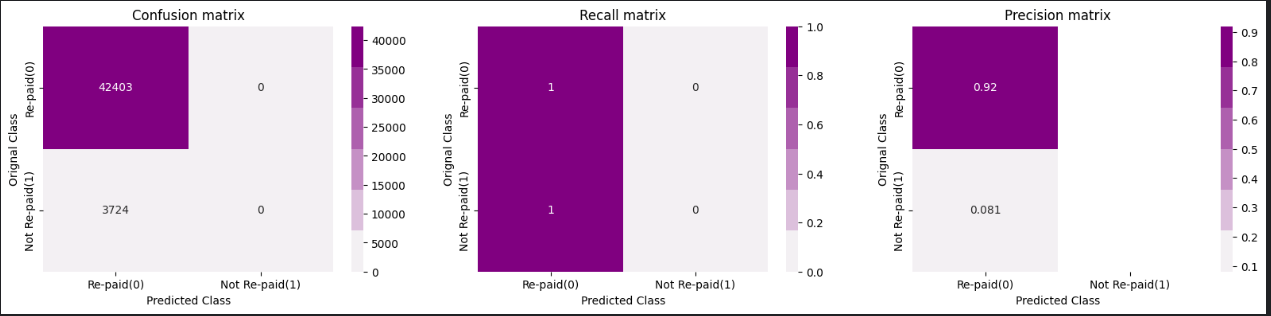

print(classification_report(y_test,y_pred_RF_final_S))

                 precision    recall  f1-score   support

           0       0.92      1.00      0.96     42403
           1       0.00      0.00      0.00      3724

    accuracy                           0.92     46127
   macro avg       0.46      0.50      0.48     46127
weighted avg       0.85      0.92      0.88     46127

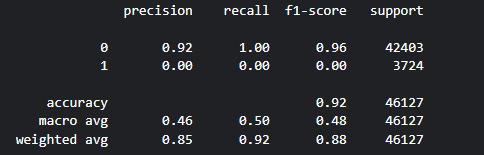

fpr,tpr,threshold = roc_curve(y_test,y_pred_prob_RF_opt_test_S)

In [ ]:
#auc_RF_S=roc_auc_score(y_testy_pred_prob_RF_opt_test_S)
#auc_RF_S


####
plt.plot(fpr,tpr,marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig('ROC_curve.png')

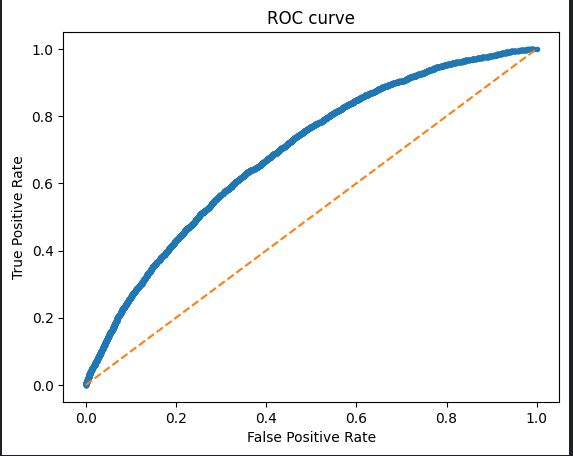

MLFLOW: déploiement du modèle

In [ ]:
!pip install mlflow --quiet
!pip install pyngrok --quiet
import mlflow
from mlflow.models import infer_signature

In [ ]:
from mlflow.models.signature import infer_signature

In [ ]:
signature=infer_signature(X_train_s_final,y_train_s)

In [ ]:
import mlflow.sklearn

In [ ]:
mlflow.sklearn.save_model(model_Log_S,'mlflow_model',signature=signature)